In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/collections2.zip

In [7]:
!find . -name '.DS_Store' -type f -delete

In [8]:
import pandas as pd
import os
import numpy as np

import os
import matplotlib.pyplot as plt
import skimage
import re
import numpy as np
import cv2
from skimage import io
from IPython.display import clear_output

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [9]:
whole = pd.read_csv("/content/drive/MyDrive/whole_dataset.csv", index_col=0)
whole['full_name'] = whole['collection']+'/'+whole['name']
whole = whole.sort_values(by=['collection', 'name'])

In [10]:
for x in ['price']:
    q75,q25 = np.percentile(whole.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    whole.loc[whole[x] < min,x] = np.nan
    whole.loc[whole[x] > max,x] = np.nan

In [11]:
whole.isnull().sum()

name              0
price         10317
collection        0
label             0
full_name         0
dtype: int64

In [12]:
whole.dropna(inplace=True)

In [13]:
whole.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,price,label
count,88770,88770
mean,9241.47,1.76696
std,11572.7,1.30902
min,1,0
25%,1224,1
50%,4049,2
75%,13000,3
max,48340,4


In [14]:
whole['price_quartile'] = (
    pd.qcut(whole['price'], 4, labels=[0, 1, 2, 3])
)

In [15]:
whole.drop(columns=['label'], inplace=True)

In [16]:
df = whole
df

,name,price,collection,full_name,price_quartile
3048,Akuma #3050,3655.0,akumaorigins,akumaorigins/Akuma #3050,1
3939,Bone Slayer #3940,2772.0,akumaorigins,akumaorigins/Bone Slayer #3940,1
577,Dovah Priest #579,1761.0,akumaorigins,akumaorigins/Dovah Priest #579,1
1711,Ghost of the Realm #1707,2390.0,akumaorigins,akumaorigins/Ghost of the Realm #1707,1
50,Hakuma #42,3406.0,akumaorigins,akumaorigins/Hakuma #42,1
...,...,...,...,...,...
9971,VaynerSports Pass #9982,2296.0,vaynersports-pass-vsp,vaynersports-pass-vsp/VaynerSports Pass #9982,1
9996,VaynerSports Pass #9983,2296.0,vaynersports-pass-vsp,vaynersports-pass-vsp/VaynerSports Pass #9983,1
9925,VaynerSports Pass #9984,1408.0,vaynersports-pass-vsp,vaynersports-pass-vsp/VaynerSports Pass #9984,1
1023,VaynerSports Pass #999,1874.0,vaynersports-pass-vsp,vaynersports-pass-vsp/VaynerSports Pass #999,1


In [17]:
image_names = []
for dir in os.listdir("collections"):
    for file in os.listdir("collections/" + dir):
        filename = os.fsdecode(file)
        image_names.append(dir+"/"+os.path.splitext(filename)[0])

In [18]:
image_names_set = set(image_names)
df_names_set = set(df.full_name.apply(lambda x: str(x)).values)

In [19]:
difference = image_names_set - df_names_set
difference

{'doodles-official/Doodle #7282',
 'doodles-official/Doodle #5277',
 'doodles-official/Doodle #9789',
 'proof-moonbirds/#6039',
 'azuki/Azuki #8352',
 'azuki/Azuki #1570',
 'boredapeyachtclub/9852',
 'proof-moonbirds/#2832',
 'boredapeyachtclub/9694',
 'boredapeyachtclub/6847',
 'boredapeyachtclub/1373',
 'doodles-official/Doodle #9562',
 'proof-moonbirds/#8725',
 'doodles-official/Doodle #4668',
 'clonex/CloneX #13749',
 'azuki/Azuki #4185',
 'boredapeyachtclub/7500',
 'azuki/Azuki #1307',
 'proof-moonbirds/#5223',
 'boredapeyachtclub/7051',
 'boredapeyachtclub/162',
 'boredapeyachtclub/8993',
 'azuki/Azuki #8769',
 'azuki/Azuki #6198',
 'azuki/Azuki #8235',
 'azuki/Azuki #9264',
 'boredapeyachtclub/5622',
 'boredapeyachtclub/9627',
 'boredapeyachtclub/7146',
 'proof-moonbirds/#9554',
 'azuki/Azuki #2924',
 'clonex/CloneX #11964',
 'boredapeyachtclub/1845',
 'boredapeyachtclub/9047',
 'azuki/Azuki #7268',
 'boredapeyachtclub/5057',
 'clonex/CloneX #11033',
 'proof-moonbirds/#1124',
 '

In [20]:
for elem in difference:
      try:
          os.remove(f'collections/{elem}.png')
      except:
          os.remove(f'collections/{elem}.jpeg')

In [21]:
def read_files(collections):
    # i = 0
    X = []
    for coll in sorted(os.listdir(collections)):
        files = sorted(os.listdir(f"/content/collections/{coll}"))
        for name in files:
            img = cv2.imread(f"/content/collections/{coll}" + '/' + name)
            img = cv2.resize(img, (126, 126))
            X.append(img)
    return X

In [22]:
X = read_files("/content/collections")

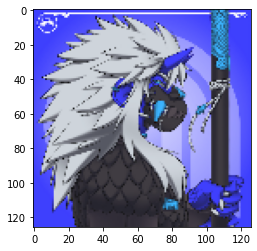

In [23]:
image = skimage.img_as_ubyte(X[0])
plt.imshow(image)

In [24]:
Y = df.price_quartile.values

In [25]:
class NftDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.X = x
        self.Y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        img = skimage.img_as_ubyte(self.X[index])
        if self.transform:
            img = self.transform(img)
        return img, self.Y[index]

In [26]:
transform_img = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Resize((224,224))
])

In [27]:
dataset = NftDataset(X, Y, transform_img)
train_set, test_set = torch.utils.data.random_split(dataset, [round(0.7*len(dataset)), round(0.3*len(dataset))])

train_loader = DataLoader(dataset=train_set, batch_size=128, drop_last=True, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=128, shuffle=True)

In [28]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 3, 224, 224]) torch.Size([128])


In [31]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.fc = nn.Linear(4096, 4)
_ = model.cuda()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [32]:
criterion = torch.nn.CrossEntropyLoss()
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr)
num_epochs = 10

In [33]:
train_losses = []
val_losses = []

train_metrics = []
val_metrics = []

hist = {"train_loss": [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": []}

Epoch 9/10	 Loss mean: 0.634752	 Accuracy mean: 0.698808
Epoch 9/10	 Val Loss mean: 0.840371	 Test Accuracy mean: 0.627024


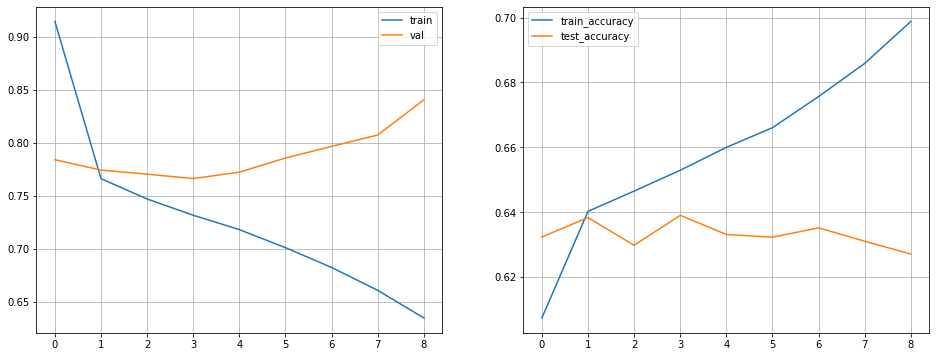

Epoch: 10 	Loss: 0.594686
Epoch: 10 	Loss: 0.590850
Epoch: 10 	Loss: 0.622628
Epoch: 10 	Loss: 0.532176
Epoch: 10 	Loss: 0.512438
Epoch: 10 	Loss: 0.517527
Epoch: 10 	Loss: 0.537265
Epoch: 10 	Loss: 0.522670
Epoch: 10 	Loss: 0.562915
Epoch: 10 	Loss: 0.633141
Epoch: 10 	Loss: 0.648676
Epoch: 10 	Loss: 0.732050
Epoch: 10 	Loss: 0.488453
Epoch: 10 	Loss: 0.490903
Epoch: 10 	Loss: 0.666041
Epoch: 10 	Loss: 0.719441
Epoch: 10 	Loss: 0.618787
Epoch: 10 	Loss: 0.561072
Epoch: 10 	Loss: 0.582717
Epoch: 10 	Loss: 0.603120
Epoch: 10 	Loss: 0.571407
Epoch: 10 	Loss: 0.529908
Epoch: 10 	Loss: 0.504897
Epoch: 10 	Loss: 0.660951
Epoch: 10 	Loss: 0.619409
Epoch: 10 	Loss: 0.591691
Epoch: 10 	Loss: 0.647219
Epoch: 10 	Loss: 0.750852
Epoch: 10 	Loss: 0.648660
Epoch: 10 	Loss: 0.625900
Epoch: 10 	Loss: 0.649826
Epoch: 10 	Loss: 0.500401
Epoch: 10 	Loss: 0.598808
Epoch: 10 	Loss: 0.666112
Epoch: 10 	Loss: 0.587221
Epoch: 10 	Loss: 0.595998
Epoch: 10 	Loss: 0.712959
Epoch: 10 	Loss: 0.617959
Epoch: 10 	L

In [34]:
for i in range(num_epochs):
    if i > 0:
        print("Epoch %d/%d\t Loss mean: %f\t Accuracy mean: %f"% \
                (i, num_epochs, epoch_loss, epoch_accuracy))
        print("Epoch %d/%d\t Val Loss mean: %f\t Test Accuracy mean: %f"% \
            (i, num_epochs, test_loss, test_accuracy))

        plt.figure(figsize=(16, 6))
        plt.subplot(121)
        plt.plot(hist['train_loss'], label='train')
        plt.plot(hist['test_loss'], label='val')
        plt.legend()
        plt.grid()

        plt.subplot(122)
        plt.plot(hist['train_accuracy'], label='train_accuracy')
        plt.plot(hist['test_accuracy'], label='test_accuracy')
        plt.legend()
        plt.grid()
        plt.show()


    epoch_losses = []
    test_losses = []
    epoch_accuracies = []
    test_accuracies = []

    model.train()
    for k, (X, Y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X.cuda())
        loss = criterion(y_pred, Y.cuda())
        accuracy = (torch.argmax(y_pred.detach().cpu(), 1) == Y.cpu()).sum()/len(Y)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accuracies.append(accuracy)
        if k%10 == 0:
            print("Epoch: %d \tLoss: %f"%(i+1, loss.item()))

    epoch_loss = np.mean(np.array(epoch_losses))
    epoch_accuracy = np.mean(np.array(epoch_accuracies))
    hist['train_accuracy'].append(epoch_accuracy)
    hist['train_loss'].append(epoch_loss)

    with torch.no_grad():
        model.eval()
        for k, (X, Y) in enumerate(test_loader):
            y_pred = model(X.cuda())
            loss = criterion(y_pred, Y.cuda())
            accuracy = (torch.argmax(y_pred.detach().cpu(), 1) == Y.cpu()).sum()/len(Y)
            test_losses.append(loss.item())
            test_accuracies.append(accuracy)

    test_loss = np.mean(np.array(test_losses))
    test_accuracy = np.mean(np.array(test_accuracies))
    hist['test_loss'].append(test_loss)
    hist['test_accuracy'].append(test_accuracy)
    
    if i < (num_epochs - 1):
        clear_output()

In [ ]:
from torchviz import make_dot

make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

In [ ]:
!pip install torchviz